In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.transformer import transformer_encoder

2023-07-22 17:07:24.236230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 17:07:25.853864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [6]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
headsize = 64*2
ff_dim = 64
num_transformer_blocks = 1
num_heads = 1
mlp_units = 32
dropout = 0.4
mlp_dropout = 0.3
masked_value = 1e-10
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [7]:
model = transformer_encoder(input_shape,
                            head_size=headsize, 
                            num_heads=num_heads, 
                            ff_dim=ff_dim, 
                            num_transformer_blocks=num_transformer_blocks, 
                            mlp_units=mlp_units, 
                            dropout=dropout, 
                            mlp_dropout=mlp_dropout,
                            masked_value=masked_value
                           )
model.summary()

2023-07-22 00:50:02.119775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 16)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 96, 16)               0         ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 96, 16)               8592      ['masking[0][0]',             
 iHeadAttention)                                                     'masking[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 96, 16)               0         ['multi_head_attention[0][

In [8]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/transformer_encoder_gate_pump.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-21 16:59:18.170367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-21 16:59:19.223926: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc6c802b180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-21 16:59:19.223975: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-21 16:59:19.233619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-21 16:59:19.598887: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.12093, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 12s - loss: 0.5213 - mae: 0.5197 - val_loss: 0.0236 - val_mae: 0.1209 - 12s/epoch - 81ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.12093 to 0.10006, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 0.0822 - mae: 0.2244 - val_loss: 0.0147 - val_mae: 0.1001 - 3s/epoch - 20ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.10006 to 0.08164, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 0.0406 - mae: 0.1578 - val_loss: 0.0102 - val_mae: 0.0816 - 3s/epoch - 20ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.08164 to 0.06978, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 0.0252 - mae: 0.1239 - val_loss: 0.0076 - val_mae: 0.0698 - 3s/epoch - 20ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.06978 to 0.05703, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 0.0174 - mae: 0.1028 - val_loss: 0.0052 - val_mae: 0.0570 - 3s/epoch - 20ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.05703 to 0.05101, saving model to saved_models/tra

Epoch 43/3000

Epoch 43: val_mae did not improve from 0.02737
151/151 - 3s - loss: 5.2587e-04 - mae: 0.0168 - val_loss: 0.0012 - val_mae: 0.0292 - 3s/epoch - 20ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.02737
151/151 - 3s - loss: 5.1856e-04 - mae: 0.0167 - val_loss: 0.0012 - val_mae: 0.0282 - 3s/epoch - 19ms/step
Epoch 45/3000

Epoch 45: val_mae improved from 0.02737 to 0.02659, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 5.0416e-04 - mae: 0.0164 - val_loss: 0.0010 - val_mae: 0.0266 - 3s/epoch - 20ms/step
Epoch 46/3000

Epoch 46: val_mae improved from 0.02659 to 0.02456, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 4.9674e-04 - mae: 0.0163 - val_loss: 8.7105e-04 - val_mae: 0.0246 - 3s/epoch - 20ms/step
Epoch 47/3000

Epoch 47: val_mae improved from 0.02456 to 0.02444, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 4.9451e-04 - mae: 0.0162 - val_loss: 8.6

Epoch 85/3000

Epoch 85: val_mae did not improve from 0.01659
151/151 - 3s - loss: 3.0595e-04 - mae: 0.0123 - val_loss: 4.8409e-04 - val_mae: 0.0169 - 3s/epoch - 20ms/step
Epoch 86/3000

Epoch 86: val_mae did not improve from 0.01659
151/151 - 3s - loss: 3.1005e-04 - mae: 0.0123 - val_loss: 4.9494e-04 - val_mae: 0.0170 - 3s/epoch - 20ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.01659
151/151 - 3s - loss: 3.0144e-04 - mae: 0.0121 - val_loss: 5.1285e-04 - val_mae: 0.0176 - 3s/epoch - 20ms/step
Epoch 88/3000

Epoch 88: val_mae did not improve from 0.01659
151/151 - 3s - loss: 3.0379e-04 - mae: 0.0122 - val_loss: 5.1635e-04 - val_mae: 0.0176 - 3s/epoch - 20ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.01659
151/151 - 3s - loss: 3.0819e-04 - mae: 0.0123 - val_loss: 5.0436e-04 - val_mae: 0.0172 - 3s/epoch - 20ms/step
Epoch 90/3000

Epoch 90: val_mae did not improve from 0.01659
151/151 - 3s - loss: 2.9947e-04 - mae: 0.0121 - val_loss: 4.7486e-04 - val_mae

Epoch 131/3000

Epoch 131: val_mae did not improve from 0.01499
151/151 - 3s - loss: 2.4921e-04 - mae: 0.0108 - val_loss: 4.2621e-04 - val_mae: 0.0154 - 3s/epoch - 20ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.01499
151/151 - 3s - loss: 2.4686e-04 - mae: 0.0107 - val_loss: 4.2507e-04 - val_mae: 0.0156 - 3s/epoch - 20ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.01499
151/151 - 3s - loss: 2.4794e-04 - mae: 0.0107 - val_loss: 4.6904e-04 - val_mae: 0.0163 - 3s/epoch - 20ms/step
Epoch 134/3000

Epoch 134: val_mae did not improve from 0.01499
151/151 - 3s - loss: 2.4714e-04 - mae: 0.0107 - val_loss: 4.2393e-04 - val_mae: 0.0156 - 3s/epoch - 20ms/step
Epoch 135/3000

Epoch 135: val_mae improved from 0.01499 to 0.01467, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 2.4621e-04 - mae: 0.0107 - val_loss: 3.8538e-04 - val_mae: 0.0147 - 3s/epoch - 20ms/step
Epoch 136/3000

Epoch 136: val_mae did not improve from 0.01467

Epoch 177/3000

Epoch 177: val_mae did not improve from 0.01442
151/151 - 3s - loss: 2.2005e-04 - mae: 0.0101 - val_loss: 3.7372e-04 - val_mae: 0.0146 - 3s/epoch - 20ms/step
Epoch 178/3000

Epoch 178: val_mae improved from 0.01442 to 0.01441, saving model to saved_models/transformer_encoder_gate_pump.h5
151/151 - 3s - loss: 2.1795e-04 - mae: 0.0100 - val_loss: 3.6134e-04 - val_mae: 0.0144 - 3s/epoch - 20ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.01441
151/151 - 3s - loss: 2.1807e-04 - mae: 0.0100 - val_loss: 3.8856e-04 - val_mae: 0.0149 - 3s/epoch - 20ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.01441
151/151 - 3s - loss: 2.1722e-04 - mae: 0.0100 - val_loss: 3.9620e-04 - val_mae: 0.0154 - 3s/epoch - 20ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.01441
151/151 - 3s - loss: 2.1732e-04 - mae: 0.0100 - val_loss: 4.1781e-04 - val_mae: 0.0156 - 3s/epoch - 20ms/step
Epoch 182/3000

Epoch 182: val_mae did not improve from 0.01441

151/151 - 3s - loss: 2.0548e-04 - mae: 0.0097 - val_loss: 4.2236e-04 - val_mae: 0.0157 - 3s/epoch - 20ms/step
Epoch 224/3000

Epoch 224: val_mae did not improve from 0.01412
151/151 - 3s - loss: 2.0538e-04 - mae: 0.0097 - val_loss: 3.8161e-04 - val_mae: 0.0149 - 3s/epoch - 20ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.01412
151/151 - 3s - loss: 2.0473e-04 - mae: 0.0097 - val_loss: 3.7980e-04 - val_mae: 0.0150 - 3s/epoch - 20ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.01412
151/151 - 3s - loss: 2.0538e-04 - mae: 0.0097 - val_loss: 3.9179e-04 - val_mae: 0.0151 - 3s/epoch - 19ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.01412
151/151 - 3s - loss: 2.0547e-04 - mae: 0.0097 - val_loss: 3.8478e-04 - val_mae: 0.0150 - 3s/epoch - 20ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.01412
151/151 - 3s - loss: 2.0515e-04 - mae: 0.0097 - val_loss: 4.0396e-04 - val_mae: 0.0156 - 3s/epoch - 20ms/step
Epoch 229/3000

Epoc


Epoch 270: val_mae did not improve from 0.01391
151/151 - 3s - loss: 1.9708e-04 - mae: 0.0095 - val_loss: 3.5148e-04 - val_mae: 0.0143 - 3s/epoch - 19ms/step
Epoch 271/3000

Epoch 271: val_mae did not improve from 0.01391
151/151 - 3s - loss: 1.9624e-04 - mae: 0.0095 - val_loss: 3.7130e-04 - val_mae: 0.0148 - 3s/epoch - 20ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.01391
151/151 - 3s - loss: 1.9611e-04 - mae: 0.0095 - val_loss: 3.8822e-04 - val_mae: 0.0151 - 3s/epoch - 20ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.01391
151/151 - 3s - loss: 1.9683e-04 - mae: 0.0095 - val_loss: 3.6375e-04 - val_mae: 0.0147 - 3s/epoch - 19ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.01391
151/151 - 3s - loss: 1.9587e-04 - mae: 0.0095 - val_loss: 3.8690e-04 - val_mae: 0.0151 - 3s/epoch - 19ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.01391
151/151 - 3s - loss: 1.9594e-04 - mae: 0.0095 - val_loss: 4.1905e-04 - val_mae: 0

Epoch 317/3000

Epoch 317: val_mae did not improve from 0.01380
151/151 - 3s - loss: 1.8987e-04 - mae: 0.0093 - val_loss: 3.5466e-04 - val_mae: 0.0144 - 3s/epoch - 20ms/step
Epoch 318/3000

Epoch 318: val_mae did not improve from 0.01380
151/151 - 3s - loss: 1.9038e-04 - mae: 0.0094 - val_loss: 3.3858e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 319/3000

Epoch 319: val_mae did not improve from 0.01380
151/151 - 3s - loss: 1.9042e-04 - mae: 0.0094 - val_loss: 3.6938e-04 - val_mae: 0.0147 - 3s/epoch - 20ms/step
Epoch 320/3000

Epoch 320: val_mae did not improve from 0.01380
151/151 - 3s - loss: 1.8862e-04 - mae: 0.0093 - val_loss: 3.9371e-04 - val_mae: 0.0152 - 3s/epoch - 19ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.01380
151/151 - 3s - loss: 1.8835e-04 - mae: 0.0093 - val_loss: 3.4603e-04 - val_mae: 0.0143 - 3s/epoch - 20ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.01380
151/151 - 3s - loss: 1.8854e-04 - mae: 0.0093 - val_loss: 3.6523e-

Epoch 363/3000

Epoch 363: val_mae did not improve from 0.01344
151/151 - 3s - loss: 1.8138e-04 - mae: 0.0092 - val_loss: 3.3506e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 364/3000

Epoch 364: val_mae did not improve from 0.01344
151/151 - 3s - loss: 1.8110e-04 - mae: 0.0091 - val_loss: 3.2161e-04 - val_mae: 0.0138 - 3s/epoch - 20ms/step
Epoch 365/3000

Epoch 365: val_mae did not improve from 0.01344
151/151 - 3s - loss: 1.8195e-04 - mae: 0.0092 - val_loss: 3.3863e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 366/3000

Epoch 366: val_mae did not improve from 0.01344
151/151 - 3s - loss: 1.8197e-04 - mae: 0.0092 - val_loss: 3.2948e-04 - val_mae: 0.0139 - 3s/epoch - 20ms/step
Epoch 367/3000

Epoch 367: val_mae did not improve from 0.01344
151/151 - 3s - loss: 1.8070e-04 - mae: 0.0091 - val_loss: 3.5547e-04 - val_mae: 0.0145 - 3s/epoch - 20ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.01344
151/151 - 3s - loss: 1.8209e-04 - mae: 0.0092 - val_loss: 3.2070e-

Epoch 409/3000

Epoch 409: val_mae did not improve from 0.01317
151/151 - 3s - loss: 1.7652e-04 - mae: 0.0090 - val_loss: 3.1358e-04 - val_mae: 0.0135 - 3s/epoch - 20ms/step
Epoch 410/3000

Epoch 410: val_mae did not improve from 0.01317
151/151 - 3s - loss: 1.7700e-04 - mae: 0.0091 - val_loss: 3.4005e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 411/3000

Epoch 411: val_mae did not improve from 0.01317
151/151 - 3s - loss: 1.7557e-04 - mae: 0.0090 - val_loss: 3.1502e-04 - val_mae: 0.0135 - 3s/epoch - 20ms/step
Epoch 412/3000

Epoch 412: val_mae did not improve from 0.01317
151/151 - 3s - loss: 1.7637e-04 - mae: 0.0090 - val_loss: 3.3752e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 413/3000

Epoch 413: val_mae did not improve from 0.01317
151/151 - 3s - loss: 1.7685e-04 - mae: 0.0091 - val_loss: 3.0241e-04 - val_mae: 0.0134 - 3s/epoch - 20ms/step
Epoch 414/3000

Epoch 414: val_mae did not improve from 0.01317
151/151 - 3s - loss: 1.7509e-04 - mae: 0.0090 - val_loss: 3.3222e-

151/151 - 3s - loss: 1.7283e-04 - mae: 0.0090 - val_loss: 3.3980e-04 - val_mae: 0.0140 - 3s/epoch - 20ms/step
Epoch 456/3000

Epoch 456: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.7296e-04 - mae: 0.0090 - val_loss: 3.2763e-04 - val_mae: 0.0137 - 3s/epoch - 20ms/step
Epoch 457/3000

Epoch 457: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.7226e-04 - mae: 0.0089 - val_loss: 3.4566e-04 - val_mae: 0.0140 - 3s/epoch - 20ms/step
Epoch 458/3000

Epoch 458: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.7262e-04 - mae: 0.0090 - val_loss: 3.4546e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 459/3000

Epoch 459: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.7131e-04 - mae: 0.0089 - val_loss: 3.4787e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 460/3000

Epoch 460: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.7197e-04 - mae: 0.0089 - val_loss: 3.2498e-04 - val_mae: 0.0138 - 3s/epoch - 20ms/step
Epoch 461/3000

Epoc

Epoch 503/3000

Epoch 503: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6898e-04 - mae: 0.0089 - val_loss: 3.2671e-04 - val_mae: 0.0135 - 3s/epoch - 20ms/step
Epoch 504/3000

Epoch 504: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6818e-04 - mae: 0.0089 - val_loss: 3.8652e-04 - val_mae: 0.0150 - 3s/epoch - 19ms/step
Epoch 505/3000

Epoch 505: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6876e-04 - mae: 0.0089 - val_loss: 2.9344e-04 - val_mae: 0.0129 - 3s/epoch - 20ms/step
Epoch 506/3000

Epoch 506: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6900e-04 - mae: 0.0089 - val_loss: 3.2462e-04 - val_mae: 0.0138 - 3s/epoch - 20ms/step
Epoch 507/3000

Epoch 507: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6809e-04 - mae: 0.0088 - val_loss: 3.4117e-04 - val_mae: 0.0140 - 3s/epoch - 20ms/step
Epoch 508/3000

Epoch 508: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6785e-04 - mae: 0.0088 - val_loss: 3.6827e-


Epoch 550: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6573e-04 - mae: 0.0088 - val_loss: 3.7899e-04 - val_mae: 0.0149 - 3s/epoch - 20ms/step
Epoch 551/3000

Epoch 551: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6459e-04 - mae: 0.0088 - val_loss: 3.3608e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 552/3000

Epoch 552: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6705e-04 - mae: 0.0088 - val_loss: 3.5010e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 553/3000

Epoch 553: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6582e-04 - mae: 0.0088 - val_loss: 3.3864e-04 - val_mae: 0.0139 - 3s/epoch - 20ms/step
Epoch 554/3000

Epoch 554: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6591e-04 - mae: 0.0088 - val_loss: 3.6798e-04 - val_mae: 0.0148 - 3s/epoch - 20ms/step
Epoch 555/3000

Epoch 555: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6552e-04 - mae: 0.0088 - val_loss: 3.3619e-04 - val_mae: 0

151/151 - 3s - loss: 1.6362e-04 - mae: 0.0087 - val_loss: 3.4746e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 598/3000

Epoch 598: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6338e-04 - mae: 0.0087 - val_loss: 3.5017e-04 - val_mae: 0.0142 - 3s/epoch - 20ms/step
Epoch 599/3000

Epoch 599: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6409e-04 - mae: 0.0088 - val_loss: 3.6240e-04 - val_mae: 0.0145 - 3s/epoch - 19ms/step
Epoch 600/3000

Epoch 600: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6403e-04 - mae: 0.0088 - val_loss: 3.5151e-04 - val_mae: 0.0143 - 3s/epoch - 19ms/step
Epoch 601/3000

Epoch 601: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6373e-04 - mae: 0.0087 - val_loss: 3.3295e-04 - val_mae: 0.0139 - 3s/epoch - 20ms/step
Epoch 602/3000

Epoch 602: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6375e-04 - mae: 0.0088 - val_loss: 4.0202e-04 - val_mae: 0.0155 - 3s/epoch - 20ms/step
Epoch 603/3000

Epoc

Epoch 645/3000

Epoch 645: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6244e-04 - mae: 0.0087 - val_loss: 4.0287e-04 - val_mae: 0.0154 - 3s/epoch - 20ms/step
Epoch 646/3000

Epoch 646: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6183e-04 - mae: 0.0087 - val_loss: 4.0541e-04 - val_mae: 0.0154 - 3s/epoch - 19ms/step
Epoch 647/3000

Epoch 647: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6323e-04 - mae: 0.0088 - val_loss: 3.4042e-04 - val_mae: 0.0140 - 3s/epoch - 19ms/step
Epoch 648/3000

Epoch 648: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6183e-04 - mae: 0.0087 - val_loss: 3.8136e-04 - val_mae: 0.0148 - 3s/epoch - 20ms/step
Epoch 649/3000

Epoch 649: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6254e-04 - mae: 0.0087 - val_loss: 3.3047e-04 - val_mae: 0.0138 - 3s/epoch - 19ms/step
Epoch 650/3000

Epoch 650: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6180e-04 - mae: 0.0087 - val_loss: 3.6363e-


Epoch 692: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6021e-04 - mae: 0.0087 - val_loss: 3.9226e-04 - val_mae: 0.0151 - 3s/epoch - 20ms/step
Epoch 693/3000

Epoch 693: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6069e-04 - mae: 0.0087 - val_loss: 3.3041e-04 - val_mae: 0.0138 - 3s/epoch - 20ms/step
Epoch 694/3000

Epoch 694: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6103e-04 - mae: 0.0087 - val_loss: 3.8237e-04 - val_mae: 0.0149 - 3s/epoch - 20ms/step
Epoch 695/3000

Epoch 695: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6102e-04 - mae: 0.0087 - val_loss: 3.5656e-04 - val_mae: 0.0143 - 3s/epoch - 20ms/step
Epoch 696/3000

Epoch 696: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6127e-04 - mae: 0.0087 - val_loss: 3.6598e-04 - val_mae: 0.0146 - 3s/epoch - 20ms/step
Epoch 697/3000

Epoch 697: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6078e-04 - mae: 0.0087 - val_loss: 3.2525e-04 - val_mae: 0

151/151 - 3s - loss: 1.5961e-04 - mae: 0.0087 - val_loss: 3.1775e-04 - val_mae: 0.0136 - 3s/epoch - 20ms/step
Epoch 740/3000

Epoch 740: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6084e-04 - mae: 0.0087 - val_loss: 3.4310e-04 - val_mae: 0.0142 - 3s/epoch - 20ms/step
Epoch 741/3000

Epoch 741: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5964e-04 - mae: 0.0086 - val_loss: 3.6826e-04 - val_mae: 0.0146 - 3s/epoch - 20ms/step
Epoch 742/3000

Epoch 742: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6038e-04 - mae: 0.0087 - val_loss: 3.2038e-04 - val_mae: 0.0136 - 3s/epoch - 20ms/step
Epoch 743/3000

Epoch 743: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.6105e-04 - mae: 0.0087 - val_loss: 3.7096e-04 - val_mae: 0.0146 - 3s/epoch - 20ms/step
Epoch 744/3000

Epoch 744: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5952e-04 - mae: 0.0086 - val_loss: 3.6605e-04 - val_mae: 0.0146 - 3s/epoch - 19ms/step
Epoch 745/3000

Epoc

Epoch 787/3000

Epoch 787: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5934e-04 - mae: 0.0087 - val_loss: 3.4564e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 788/3000

Epoch 788: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5939e-04 - mae: 0.0086 - val_loss: 3.5929e-04 - val_mae: 0.0144 - 3s/epoch - 20ms/step
Epoch 789/3000

Epoch 789: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5916e-04 - mae: 0.0086 - val_loss: 3.7386e-04 - val_mae: 0.0146 - 3s/epoch - 19ms/step
Epoch 790/3000

Epoch 790: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5881e-04 - mae: 0.0086 - val_loss: 3.3454e-04 - val_mae: 0.0139 - 3s/epoch - 20ms/step
Epoch 791/3000

Epoch 791: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5917e-04 - mae: 0.0086 - val_loss: 3.4248e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 792/3000

Epoch 792: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5890e-04 - mae: 0.0086 - val_loss: 3.5054e-


Epoch 834: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5849e-04 - mae: 0.0086 - val_loss: 3.8653e-04 - val_mae: 0.0150 - 3s/epoch - 20ms/step
Epoch 835/3000

Epoch 835: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5760e-04 - mae: 0.0086 - val_loss: 3.4689e-04 - val_mae: 0.0141 - 3s/epoch - 20ms/step
Epoch 836/3000

Epoch 836: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5773e-04 - mae: 0.0086 - val_loss: 3.3668e-04 - val_mae: 0.0140 - 3s/epoch - 20ms/step
Epoch 837/3000

Epoch 837: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5784e-04 - mae: 0.0086 - val_loss: 3.9555e-04 - val_mae: 0.0154 - 3s/epoch - 20ms/step
Epoch 838/3000

Epoch 838: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5783e-04 - mae: 0.0086 - val_loss: 3.7785e-04 - val_mae: 0.0148 - 3s/epoch - 20ms/step
Epoch 839/3000

Epoch 839: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5808e-04 - mae: 0.0086 - val_loss: 3.2032e-04 - val_mae: 0

151/151 - 3s - loss: 1.5825e-04 - mae: 0.0086 - val_loss: 4.0592e-04 - val_mae: 0.0152 - 3s/epoch - 20ms/step
Epoch 882/3000

Epoch 882: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5723e-04 - mae: 0.0086 - val_loss: 3.6057e-04 - val_mae: 0.0144 - 3s/epoch - 20ms/step
Epoch 883/3000

Epoch 883: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5710e-04 - mae: 0.0086 - val_loss: 3.8205e-04 - val_mae: 0.0148 - 3s/epoch - 19ms/step
Epoch 884/3000

Epoch 884: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5770e-04 - mae: 0.0086 - val_loss: 3.5974e-04 - val_mae: 0.0144 - 3s/epoch - 20ms/step
Epoch 885/3000

Epoch 885: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5774e-04 - mae: 0.0086 - val_loss: 3.8652e-04 - val_mae: 0.0150 - 3s/epoch - 20ms/step
Epoch 886/3000

Epoch 886: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5741e-04 - mae: 0.0086 - val_loss: 3.5823e-04 - val_mae: 0.0143 - 3s/epoch - 19ms/step
Epoch 887/3000

Epoc

Epoch 929/3000

Epoch 929: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5674e-04 - mae: 0.0086 - val_loss: 3.6358e-04 - val_mae: 0.0144 - 3s/epoch - 20ms/step
Epoch 930/3000

Epoch 930: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5685e-04 - mae: 0.0086 - val_loss: 3.4157e-04 - val_mae: 0.0140 - 3s/epoch - 20ms/step
Epoch 931/3000

Epoch 931: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5736e-04 - mae: 0.0086 - val_loss: 4.1057e-04 - val_mae: 0.0156 - 3s/epoch - 20ms/step
Epoch 932/3000

Epoch 932: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5618e-04 - mae: 0.0086 - val_loss: 3.7089e-04 - val_mae: 0.0146 - 3s/epoch - 19ms/step
Epoch 933/3000

Epoch 933: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5793e-04 - mae: 0.0086 - val_loss: 4.0235e-04 - val_mae: 0.0151 - 3s/epoch - 20ms/step
Epoch 934/3000

Epoch 934: val_mae did not improve from 0.01281
151/151 - 3s - loss: 1.5632e-04 - mae: 0.0086 - val_loss: 3.5838e-

### Performance

In [7]:
import time

In [8]:
saved_model = load_model('saved_models/transformer_encoder_gate_pump.h5')


start_time = time.time()


yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))


end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))

2023-07-22 17:07:34.545197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1
2023-07-22 17:07:36.191505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


603/603 [==============================] - 4s 3ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0679
RMSE = 0.0905
--- 4.346430063247681 seconds ---


In [9]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_yhat.to_csv('saved_results/transformer_inv_yhat.csv')

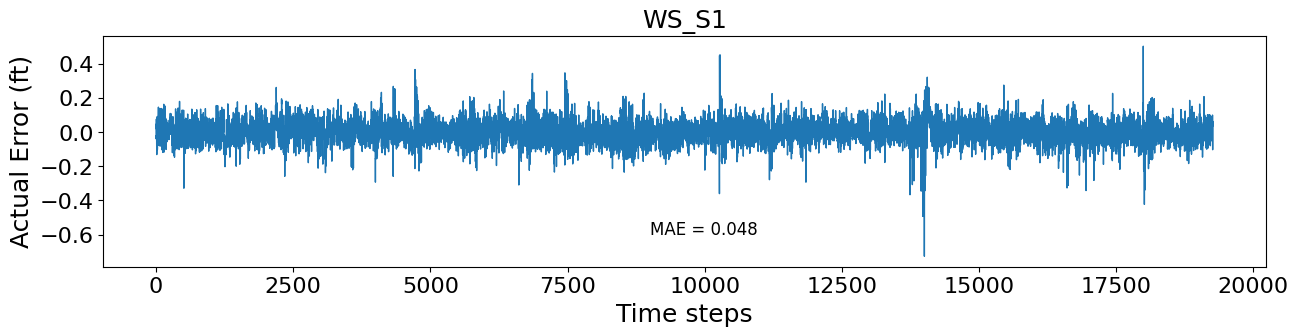

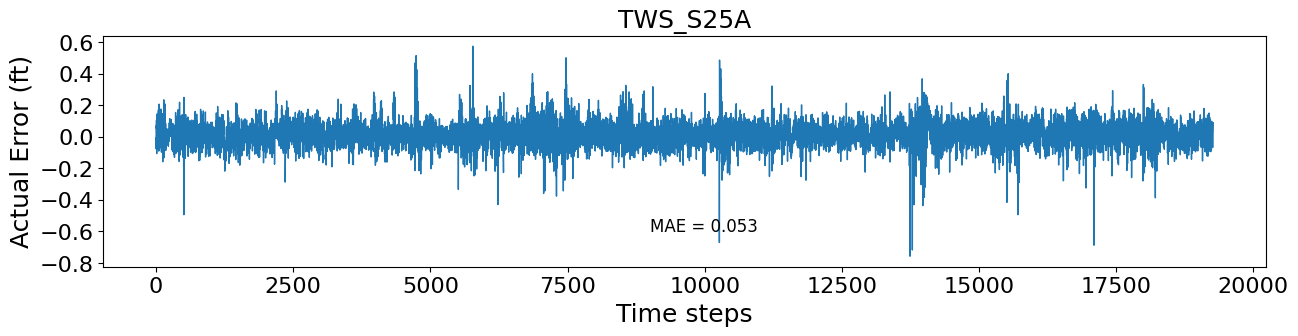

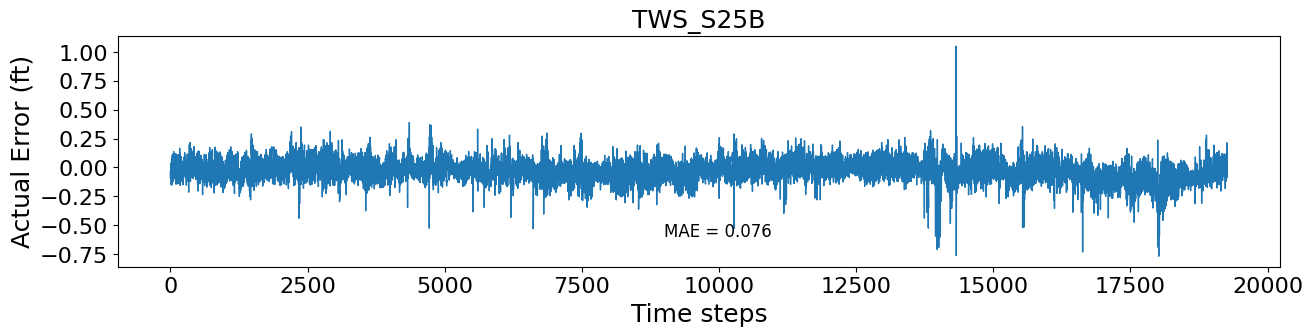

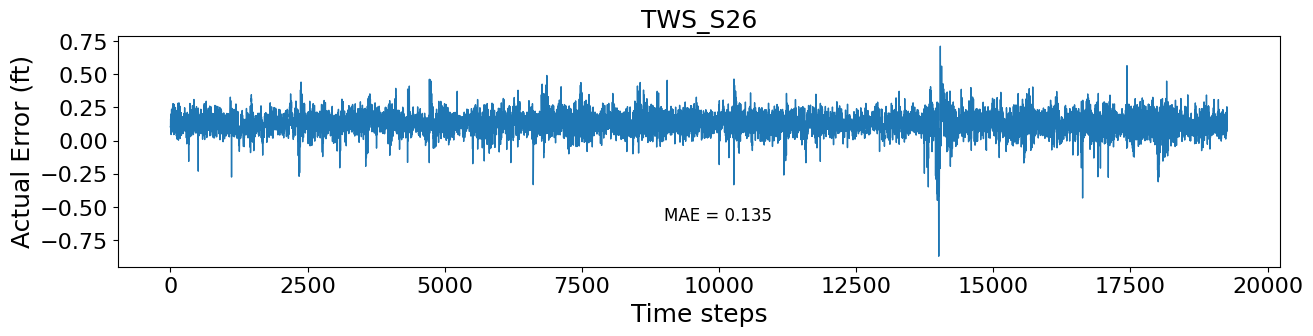

In [10]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [11]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
3
(19268,)
7
(19268,)
35
(19268,)
7


In [12]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
1
(19268,)
3
(19268,)
2
(19268,)
4


In [13]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
2
(19268,)
4
(19268,)
33
(19268,)
3
